# Preparing the Financial Data

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from sklearn.metrics import confusion_matrix, r2_score, precision_score, accuracy_score, recall_score, f1_score, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

NASDAQ Composite data

In [4]:
nasdaq = yf.download("^IXIC", start="1971-02-05", end="2020-06-05", progress=False)
nasdaq.sort_index(inplace=True)

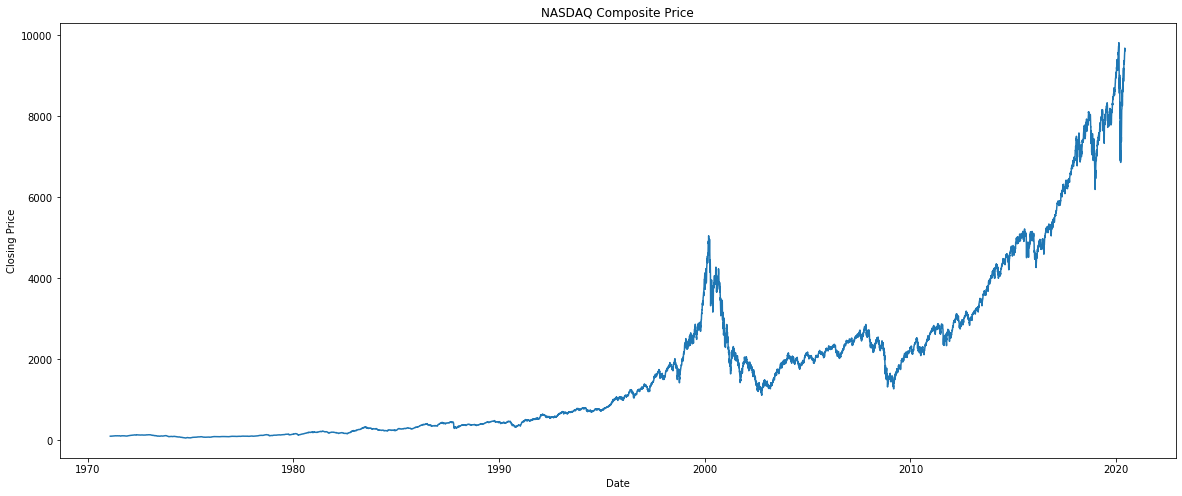

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(nasdaq['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("NASDAQ Composite Price")
plt.show()

Calculate & plot daily log return

After looking at the daily returns chart for Nasdaq we can conclude that the returns are quite volatile at some years and the stock can move +/- 15% on any given day. 
- 1980s: saving and loan crisis
- 1987s: Black Monday
- 2000s: Dot-com bubble, the collapse of internat companies
- 2008: Finacial Crisis
- 2020: Covid pandemic

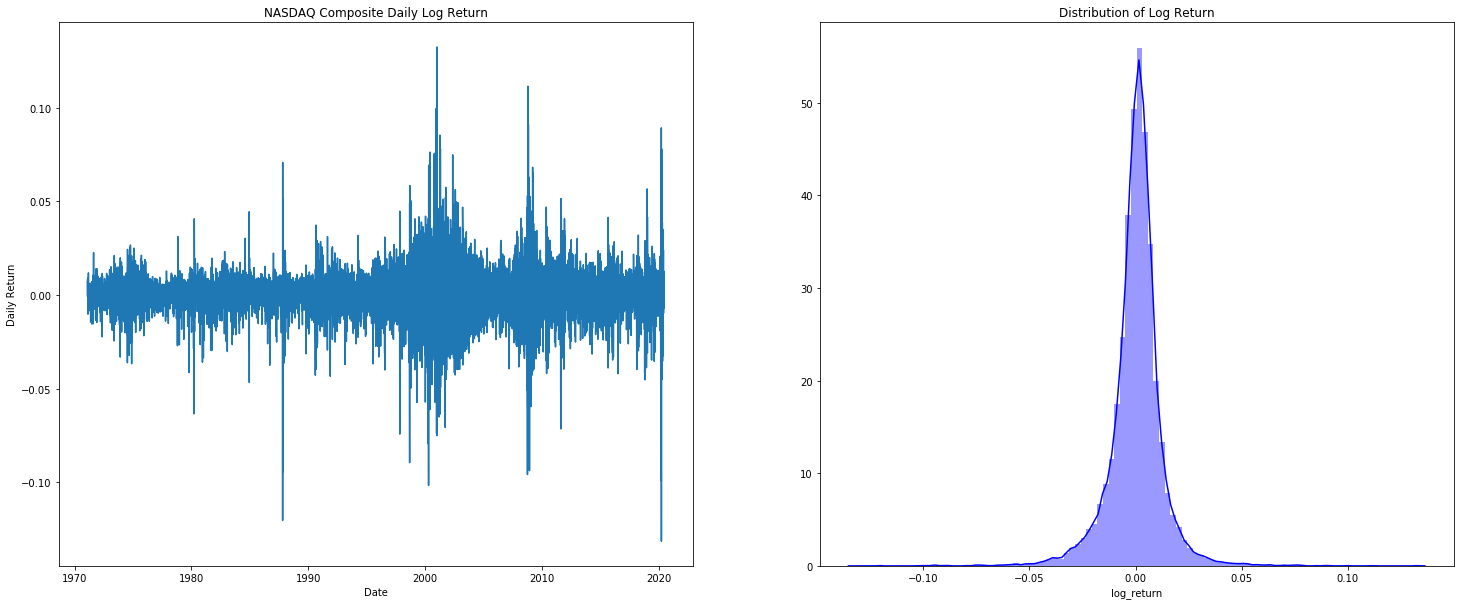

In [6]:
nasdaq['log_return'] = np.log(nasdaq.Close/nasdaq.Close.shift(1))

plt.figure(figsize=(25, 10))
plt.subplot(121)
plt.plot(nasdaq.log_return)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("NASDAQ Composite Daily Log Return")

plt.subplot(122)
sns.distplot(nasdaq.log_return, bins=100, kde=True, color='blue')
plt.title('Distribution of Log Return')
plt.show()

#### Data preparation
- Select Close Price for modeling
- Scale data as following:
$$X_{scale} = \frac{X-X_{min}}{X_{max} - X_{min}}$$

# Preparing the training and testing data

In [7]:
dataset=nasdaq[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

Because the prices have serial correlation, then train and label created:

- A single data point contain 60 features corresponding 60 previous data points
- A label (ground truth) is data point at day 61

In [8]:
rolling_windows = 60
features, labels = [], []
for i in range(rolling_windows, len(scaled_data)):
    features.append(scaled_data[i-rolling_windows:i, 0])
    labels.append(scaled_data[i, 0])

features, labels = np.array(features), np.array(labels)
(features.shape, labels.shape)

((12382, 60), (12382,))

## Train test split with 80% training size

In [9]:
training_size = 0.8
x_train, y_train = features[:int(len(features)*training_size), :], labels[:int(len(labels)*training_size)]
x_test, y_test = features[int(len(features)*training_size):, : ], labels[int(len(labels)*training_size):]

print("x_train: ", x_train.shape, " - y_train: ", y_train.shape)
print("x_test: ", x_test.shape, " - y_test: ", y_test.shape)

x_train:  (9905, 60)  - y_train:  (9905,)
x_test:  (2477, 60)  - y_test:  (2477,)


## Reshape data for modeling

In [10]:
x_train, y_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)), np.reshape(y_train, (-1, 1))
x_test, y_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)), np.reshape(y_test, (-1, 1))

print('Train: ', (x_train.shape, y_train.shape))
print('Test: ', (x_test.shape, y_test.shape))

Train:  ((9905, 60, 1), (9905, 1))
Test:  ((2477, 60, 1), (2477, 1))


# Training the LSTM model

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=1, validation_split=.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Train on 7924 samples, validate on 1981 samples
Epoch 1/3
7924/7924 [==============================] - ETA: 9:36 - loss: 0.0219 - acc: 0.0000e+0 - ETA: 4:59 - loss: 0.0135 - acc: 0.0000e+0 - ETA: 3:26 - loss: 0.0123 - acc: 0.0000e+0 - ETA: 2:40 - loss: 0.0124 - acc: 0.0000e+0 - ETA: 2:12 - loss: 0.0116 - acc: 0.0000e+0 - ETA: 1:54 - loss: 0.0102 - acc: 0.0000e+0 - ETA: 1:40 - loss: 0.0093 - acc: 0.0

- Predict close price, note that this is scaled close price following MinMaxScaler
- Calculate root mean square and R_2 score

# Model Results

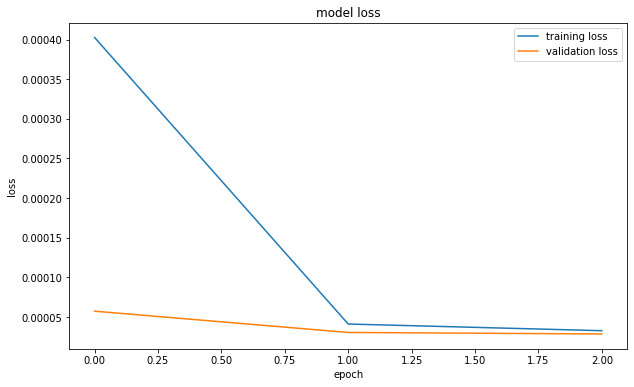

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

In [25]:
predicted_price = model.predict(x_test)

rms = np.sqrt(np.mean(np.power((y_test - predicted_price), 2)))
r2_score = r2_score(y_test, predicted_price) *100
(rms, r2_score)

0.0214136906319423 98.86644860962181


In [37]:
truncated_nasdag = nasdaq[rolling_windows: ]

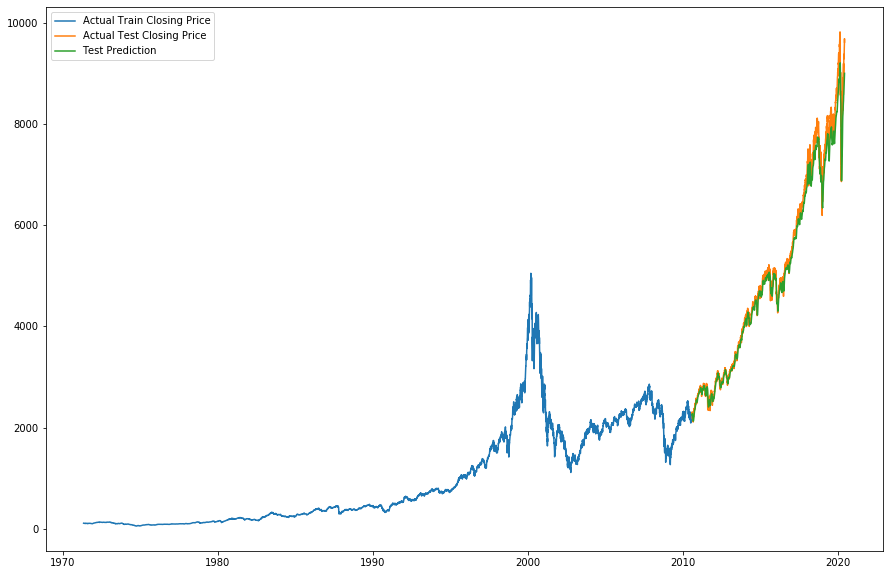

In [38]:
train = truncated_nasdag[['Close']][: int(len(features)*training_size)]
test = truncated_nasdag[['Close']][int(len(features)*training_size): ]
test['Prediction'] = scaler.inverse_transform(predicted_price)
plt.figure(figsize=(15, 10))
plt.plot(train['Close'], label='Actual Train Closing Price')
plt.plot(test['Close'], label='Actual Test Closing Price')
plt.plot(test['Prediction'], label='Test Prediction ')
plt.legend(loc='upper left')
plt.show()

# Evaluating and Backtesting the Model

## Trading Strategy

We will use a simple moving average strategy. Using the predicted price from the LSTM model, we generate moving average signals based on a long and short window size. If the short moving average is larger than the long moving average, we enter a long position. Otherwise, we exit the position.

- Long mavg: Long moving average
- Short mavg: Short moving average
- If `short_mavg` > `long_mavg` --> Buy
- If `short_mavg` < `long_mavg` --> Sell

We first prepare the signals. We generate the moving average columns using the predicted stock prices and shift them upwards by 1 to prevent lookahead bias. In other words, we are using the moving average value of the previous day to make trading decisions for the next day.

Next, we can start with the actual backtesting. We generate a column of positions that we are expected to have at each point in time, based on the moving average signals. Based on the positions, we are able to generate our portfolio value at each point in time, where a long position of 1 will simply translate to a portfolio value of the asset closing price at that point in time. If the position is 0, our portfolio value is simply just the price which we exited the position at. This is equivalent to the most recent closing price during our most recent long position. This can be achieved by filling up all the remaining na values, with the most recent value using the ffill method. 

Lastly, for our inital positions at the start of the backtesting where we have yet to enter any positions, we fill them up with the stock value at the starting date. Then, we compute a new column strategyReturns which computes the log returns based on our changes in the portfolio value.

A plot of buy and sell signals are shown below.

In [39]:
# Strategy Parameters
short_window = 40
long_window = 150

startTestDate = truncated_nasdag[int(len(features)*training_size): ].index[0]

In [40]:
def create_signals_df(df_close, startTestDate):
    # Initialize the signal DataFrame with signal column
    signals = pd.DataFrame(index=df_close.index)
    signals['Close'] = df_close['Close']
    
    signals['position'] = 0.0
    signals['portfolio'] = float("Nan")
    # Create short and long simple moving average over the short and long window
    signals['short_mavg'] = df_close['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = df_close['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    #Shift up by 1 to prevent lookahead bias
    signals['long_mavg'] = signals['long_mavg'].shift(1)
    signals['short_mavg'] = signals['short_mavg'].shift(1)

    #Create signals: if short mavg > long mavg --> buy, otherwise.
    signals['position'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    # Generate trading orders
    signals['action'] = signals['position'].diff()
    
    # Generate trading orders
    signals['portfolio'][signals['position'] == 1] = signals['Close']
    signals['portfolio'] = signals['portfolio'].fillna(method='ffill')
    signals['portfolio'] = signals['portfolio'].fillna(signals.loc[startTestDate]['Close'])
    signals['strategyReturns'] = np.log(signals.portfolio/signals.portfolio.shift(1))
    
    return signals

In [41]:
def plot_signals(signals_df):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111, ylabel='Price in $')
    signals_df['Close'].plot(ax=ax1, color='r', lw=2., label='Closing price')
    signals_df[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the buy signals
    ax1.plot(signals_df.loc[signals_df.action == 1.0].index, 
             signals_df.short_mavg[signals_df.action == 1.0], 
             '^', markersize=10, color='m', label='Buy signals')

    # Plot the sell signals
    ax1.plot(signals_df.loc[signals_df.action == -1.0].index, 
             signals_df.short_mavg[signals_df.action == -1.0], 
             'v', markersize=10, color='k', label='Sell signals')

    plt.legend(loc='upper left')
    plt.show()

Actual signal

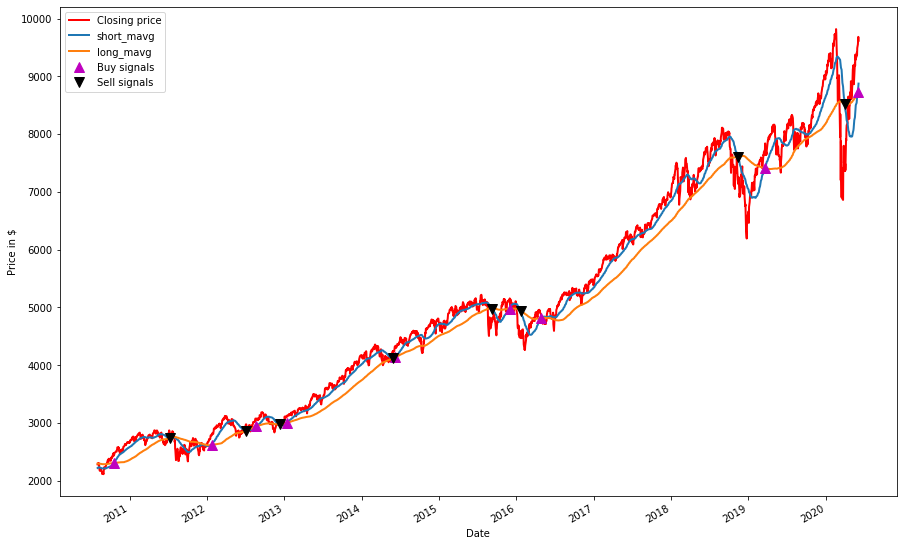

In [42]:
signals = create_signals_df(truncated_nasdag, startTestDate)
plot_signals(signals.query('index >= @startTestDate'))

Prediction signal

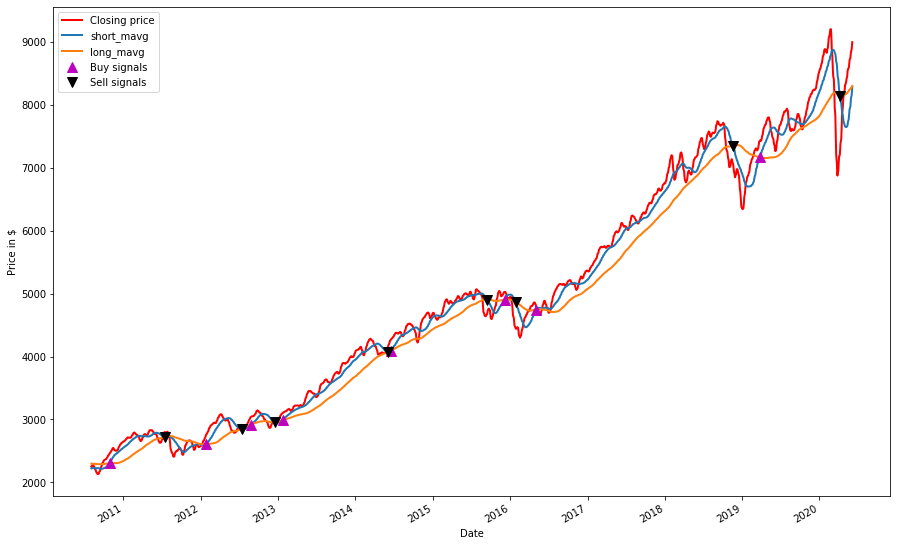

In [43]:
predicted_data = pd.concat([train, test[['Prediction']].rename(columns={'Prediction': 'Close'})])
signals_predicted = create_signals_df(predicted_data, startTestDate)
plot_signals(signals_predicted.query('index >= @startTestDate'))

# Performance Metrics

Building confusion matrix

In [188]:
signals_test = signals.query('index >= @startTestDate')
signals_predicted_test = signals_predicted.query('index >= @startTestDate')

In [189]:
cm = confusion_matrix(signals_test.action, signals_predicted_test.action, labels=[-1, 0, 1])
print("Initial Confusion matrix \n", cm)

Initial Confusion matrix 
 [[   0    8    0]
 [   8 2444    8]
 [   0    9    0]]


In [190]:
# Accuracy score of confusion matrix
accuracy_score(signals_test.action, signals_predicted_test.action)

0.9866774323778764

In [191]:
print(classification_report(signals_test.action, signals_predicted_test.action))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         8
         0.0       0.99      0.99      0.99      2460
         1.0       0.00      0.00      0.00         9

   micro avg       0.99      0.99      0.99      2477
   macro avg       0.33      0.33      0.33      2477
weighted avg       0.99      0.99      0.99      2477



**Nevertheless, we see observe that confusion matrix presumes poor prediction for sell and buy signals. Additionally, classification report computes 0 precision, recall and f1-score. Moreover, its accuracy score is very high, that may lead to wrong conclusion about correctness of confusion matrix. With deeper analysis, we can get more reliable and correct estimates for this performance metrics.**

In [192]:
print(signals_test["action"].value_counts())
print(signals_predicted_test["action"].value_counts())

 0.0    2460
 1.0       9
-1.0       8
Name: action, dtype: int64
 0.0    2461
-1.0       8
 1.0       8
Name: action, dtype: int64


In [193]:
test_minus1 = (signals_test[signals_test["action"] == -1 ].index.values)
print("Actual sell signal dates")
print(test_minus1)
predicted_test_minus1 = (signals_predicted_test[signals_predicted_test["action"] == -1 ].index.values)
print("Predicted sell signal dates")
print(predicted_test_minus1)

Actual sell signal dates
['2011-07-13T00:00:00.000000000' '2012-07-03T00:00:00.000000000'
 '2012-12-13T00:00:00.000000000' '2014-05-30T00:00:00.000000000'
 '2015-09-09T00:00:00.000000000' '2016-01-21T00:00:00.000000000'
 '2018-11-13T00:00:00.000000000' '2020-04-01T00:00:00.000000000']
Predicted sell signal dates
['2011-07-19T00:00:00.000000000' '2012-07-12T00:00:00.000000000'
 '2012-12-19T00:00:00.000000000' '2014-06-05T00:00:00.000000000'
 '2015-09-15T00:00:00.000000000' '2016-01-27T00:00:00.000000000'
 '2018-11-19T00:00:00.000000000' '2020-04-07T00:00:00.000000000']


In [194]:
test_minus1 = (signals_test[signals_test["action"] == 1 ].index.values)
print("Actual buy signal dates")
print(test_minus1)
predicted_test_minus1 = (signals_predicted_test[signals_predicted_test["action"] == 1 ].index.values)
print("Predicted buy signal dates")
print(predicted_test_minus1)

Actual buy signal dates
['2010-10-20T00:00:00.000000000' '2012-01-23T00:00:00.000000000'
 '2012-08-20T00:00:00.000000000' '2013-01-14T00:00:00.000000000'
 '2014-06-09T00:00:00.000000000' '2015-11-30T00:00:00.000000000'
 '2016-04-27T00:00:00.000000000' '2019-03-20T00:00:00.000000000'
 '2020-06-01T00:00:00.000000000']
Predicted buy signal dates
['2010-10-28T00:00:00.000000000' '2012-01-27T00:00:00.000000000'
 '2012-08-24T00:00:00.000000000' '2013-01-22T00:00:00.000000000'
 '2014-06-16T00:00:00.000000000' '2015-12-07T00:00:00.000000000'
 '2016-05-03T00:00:00.000000000' '2019-03-26T00:00:00.000000000']


In [195]:
df_test_minus1 = pd.DataFrame(signals_test[signals_test["action"] == -1 ])
df_predicted_test_minus1 = pd.DataFrame(signals_predicted_test[signals_predicted_test["action"] == -1 ])
df_test_plus1 = pd.DataFrame(signals_test[signals_test["action"] == 1 ])
# we see that actual number of signals is 9, while predicted numberis 8,
# so we drop last, in our case, only to be able to find differences
df_test_plus1.drop(df_test_plus1.tail(1).index, inplace = True)
df_predicted_test_plus1 = pd.DataFrame(signals_predicted_test[signals_predicted_test["action"] == 1 ])

In [196]:
df_lag = pd.DataFrame()
df_lag['tvalue_minus1_t'] = df_test_minus1.index
df_lag['tvalue_minus1_p'] = df_predicted_test_minus1.index
df_lag['tvalue_plus1_t'] = df_test_plus1.index
df_lag['tvalue_plus1_p'] = df_predicted_test_plus1.index

In [197]:
df_lag['delta_minus1'] = (df_lag['tvalue_minus1_t']-df_lag['tvalue_minus1_p'])
df_lag['delta_plus1'] = (df_lag['tvalue_plus1_t']-df_lag['tvalue_plus1_p'])
df_lag['new_minus1'] = df_lag['delta_minus1'].apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64') / (24*60) + 6
df_lag['new_plus1'] = df_lag['delta_plus1'].apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64') / (24*60) + 6
df_lag['pred_new_minus1'] = (df_lag['new_minus1'] == 0).astype(int)+1
df_lag.loc[df_lag.pred_new_minus1 == 2, 'pred_new_minus1'] = 0
df_lag['pred_new_plus1'] = (df_lag['new_plus1'] == 0).astype(int)
df_lag['actual_minus1'] = 0
df_lag['actual_plus1'] = 1
df_lag

tvalue_minus1_t tvalue_minus1_p tvalue_plus1_t tvalue_plus1_p delta_minus1  \
0      2011-07-13      2011-07-19     2010-10-20     2010-10-28      -6 days   
1      2012-07-03      2012-07-12     2012-01-23     2012-01-27      -9 days   
2      2012-12-13      2012-12-19     2012-08-20     2012-08-24      -6 days   
3      2014-05-30      2014-06-05     2013-01-14     2013-01-22      -6 days   
4      2015-09-09      2015-09-15     2014-06-09     2014-06-16      -6 days   
5      2016-01-21      2016-01-27     2015-11-30     2015-12-07      -6 days   
6      2018-11-13      2018-11-19     2016-04-27     2016-05-03      -6 days   
7      2020-04-01      2020-04-07     2019-03-20     2019-03-26      -6 days   

  delta_plus1  new_minus1  new_plus1  pred_new_minus1  pred_new_plus1  \
0     -8 days         0.0       -2.0                0               0   
1     -4 days        -3.0        2.0                1               0   
2     -4 days         0.0        2.0                0               0   
3     -8 days         0.0       -2.0                0               0   
4     -7 days         0.0       -1.0                0               0   
5     -7 days         0.0       -1.0                0               0   
6     -6 days         0.0        0.0                0               1   
7     -6 days         0.0        0.0                0               1   

   actual_minus1  actual_plus1  
0              0             1  
1              0             1  
2              0             1  
3              0             1  
4              0             1  
5              0             1  
6              0             1  
7              0             1

**Now we see that our model has very strong 6 day shift(lag) in prediction of time of signals. After taking it into consideration we can recalculate our Performance Metrics. To be more precise, only exact date matches would be considered. In addition, we should add previously dropped observation of 9th buy signal.**

In [157]:
print(df_lag["pred_new_minus1"].value_counts())
print(df_lag["pred_new_plus1"].value_counts())

0    7
1    1
Name: pred_new_minus1, dtype: int64
0    6
1    2
Name: pred_new_plus1, dtype: int64


In [173]:
final_df = pd.DataFrame()
final_df['testy'] = df_lag.actual_minus1.append(df_lag.actual_plus1, ignore_index=True)
final_df['yhat_classes'] = df_lag.pred_new_minus1.append(df_lag.pred_new_plus1, ignore_index=True)
dropped_row = {'testy': 1, 'yhat_classes':0} # adding initally drooped row from actual_plus1
final_df = final_df.append(dropped_row, ignore_index=True)
# final_df

In [184]:
conf_matr = confusion_matrix(final_df.testy, final_df.yhat_classes)
print("New confusion matrix \n",conf_matr)

New confusion matrix 
 [[7 1]
 [7 2]]


In [180]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(final_df.testy, final_df.yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(final_df.testy, final_df.yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(final_df.testy, final_df.yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(final_df.testy, final_df.yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.529412
Precision: 0.666667
Recall: 0.222222
F1 score: 0.333333


**As we only used exact match, i.e. considered worst case scenario, so our performance metrics results are considerably lower. In reality, taking into account additional timespan of one-two trading days to catch signal would have considerable positive effect on scores, which will be more "real" values for performance metrics.**

# Backtesting Results

Now, we can generate the performance report of our strategy, and compare it against the benchmark where if we were to just passively hold the position all the way.

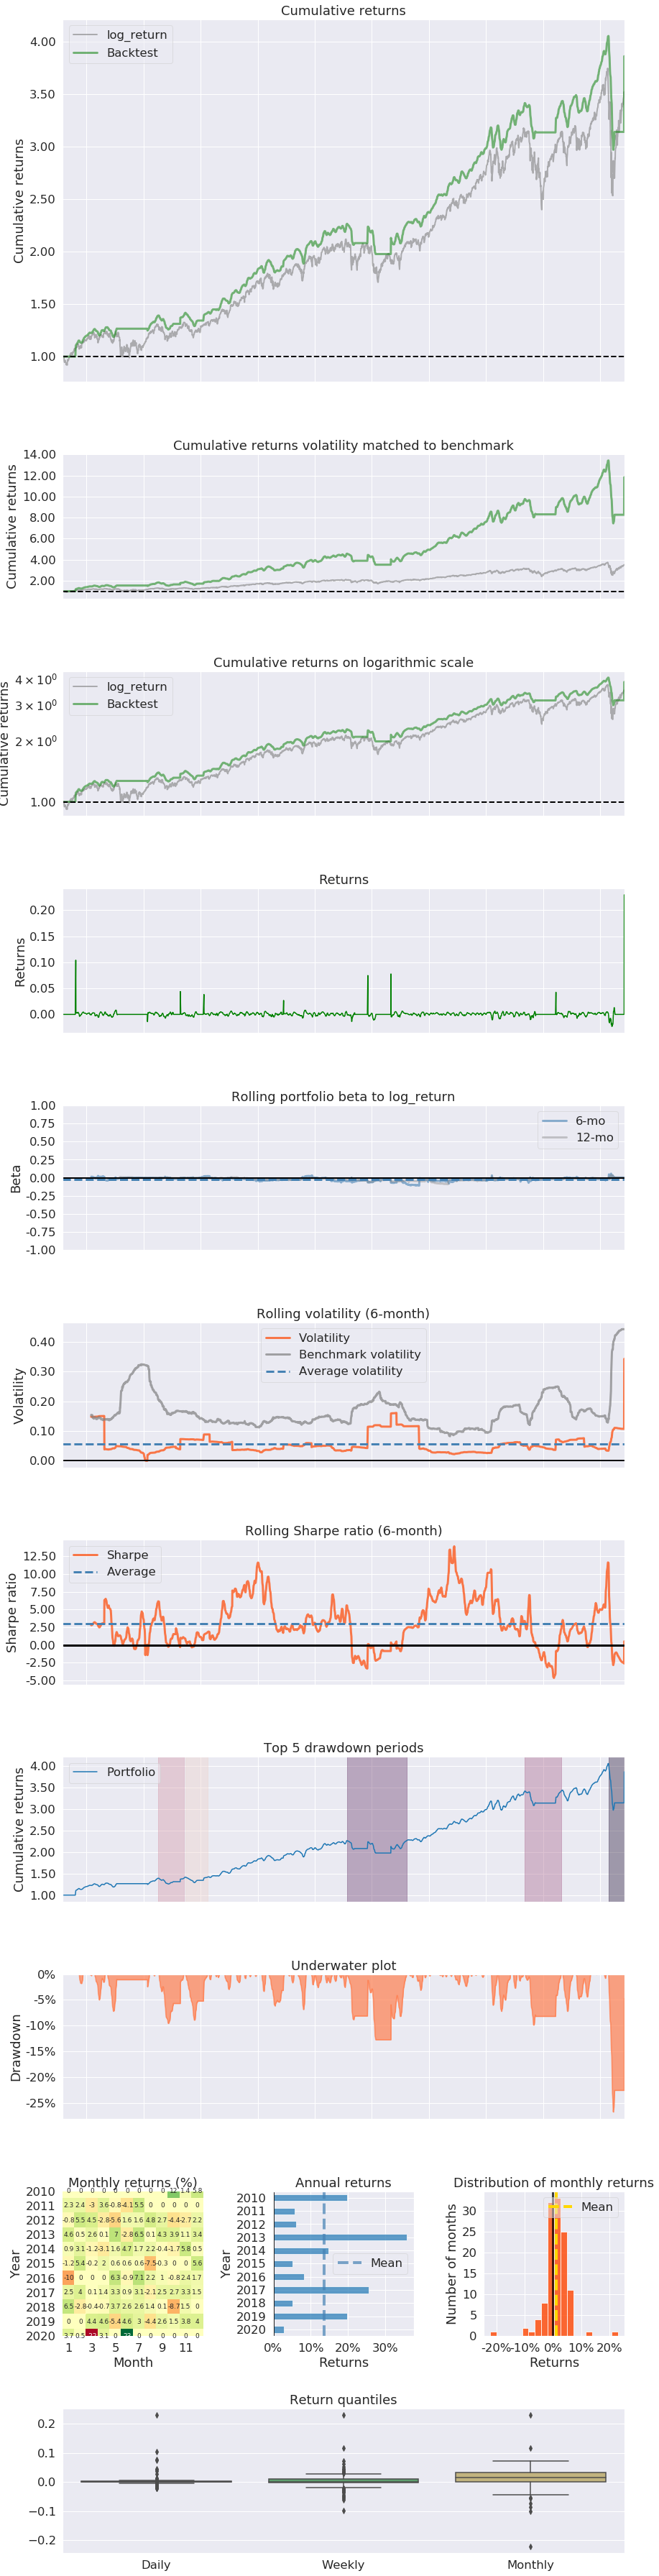

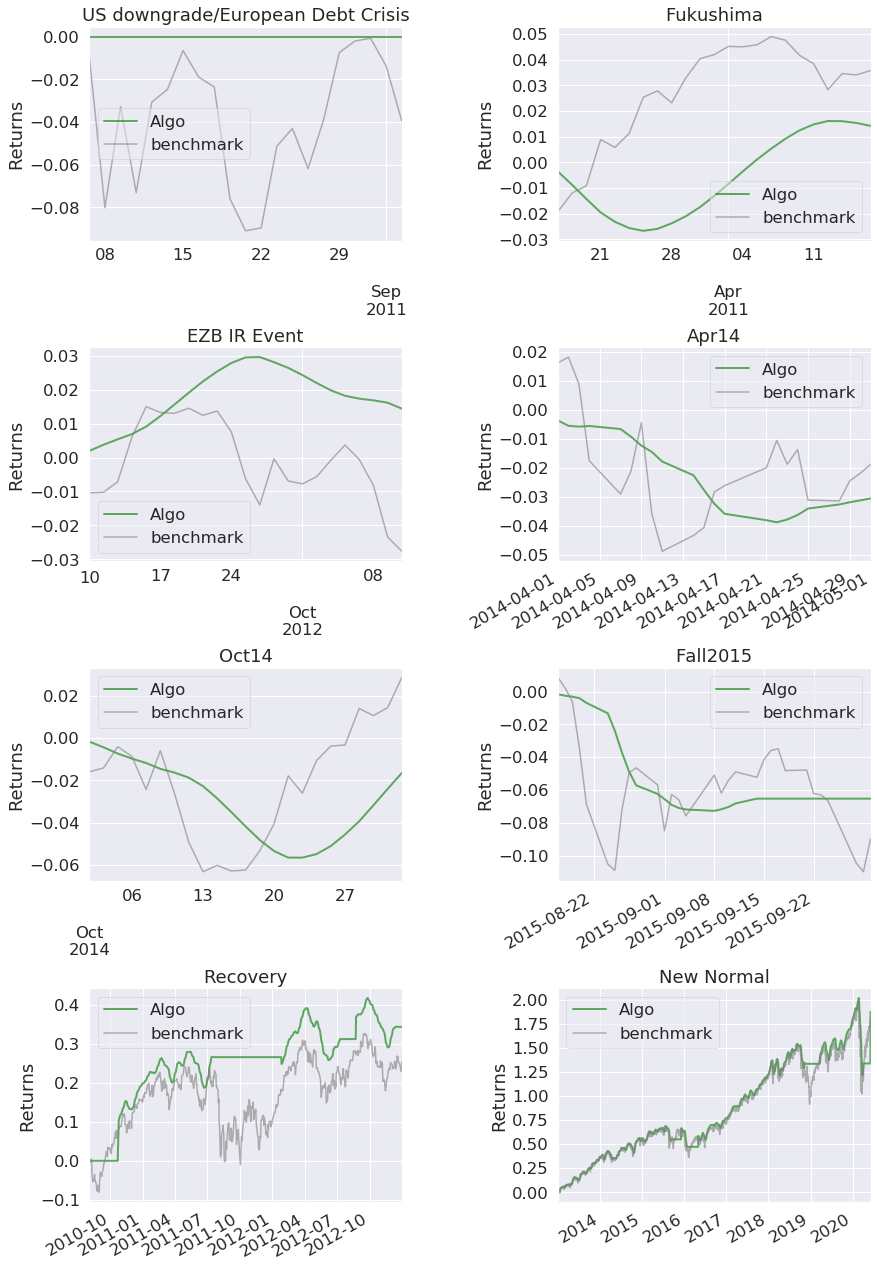

In [23]:
pf.create_full_tear_sheet(signals_predicted_test['strategyReturns'].fillna(0), benchmark_rets=nasdaq.query('index >= @startTestDate')['log_return'])

From the report, we see that we actually outperform the benchmark in the later years, but underperformed it in some of the earlier years. Overall, we achieved an alpha of 0.03 above the benchmark, and a beta of 0.69, with an annual return of 11.9%. This means that our returns do not vary too much with the benchmark, which can also be seen from our lower volatility. We managed to achieve a Sharpe ratio of 0.76.